In [1]:
from __future__ import print_function, division
import scipy


import keras
from keras.datasets import mnist
#from keras_contrib.layers.normalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
import datetime
import matplotlib.pyplot as plt
import sys
from data_loader import DataLoader
import numpy as np
import os
from glob import glob

Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: TITAN X (Pascal) (0000:01:00.0)


In [2]:
def gen_data(f_mean_shift=(2,3), fvar=2, g_mean_shift=(-1,-1), gvar=0.5, num_pts=10000, mean=(0,0), var=1.0, batch_size=1):
        #data_type = "train%s" % domain if not is_testing else "test%s" % domain
        cov=var*np.eye(2)
        orig = np.random.multivariate_normal(mean, cov, num_pts)
        fmean=np.asarray(mean)+np.asarray(f_mean_shift)
        fpts= np.random.multivariate_normal(fmean, fvar*cov, num_pts)
        gmean=np.asarray(mean)+np.asarray(g_mean_shift)
        gpts=np.random.multivariate_normal(gmean, gvar*cov, num_pts)

        return orig, fpts, gpts

In [3]:
#translate from one determinisitcally generated distribution to another 
def translate_pt(a_pt, a_mean=(2,3), avar=2, b_mean=(-1,-1), bvar=0.5, mean=(0,0), var=1.0):
    #think of the point-mean as a vector that is scaled by the variance of the distribution 
    vec=(np.asarray(a_pt)-np.asarray(a_mean))
    #divide by the original dist's variance, re-scale by the new variance
    #the shift the vector to its new starting place, the mean of the target distribution
    b_trans_pt=np.asarray(np.asarray((np.asarray(vec)/avar))*bvar)+np.asarray(b_mean)
    return b_trans_pt



In [4]:
class CycleGANRL():
    def __init__(self, data_A, data_B, lr_G=0.001, lr_D=0.0005, lambda_cycle=1, 
                 disclossconst=1, idloss=0.01, disclossfunc='binary_crossentropy', seed=997):
        
        #
        self.data_shape=(2,)
        self.data_dim=2
        self.disclossconst=disclossconst
        self.idloss=idloss
        self.disclossfunc=disclossfunc
        self.seed=seed

        # Loss weights
        ##################################
        # First change: set cycle-consistency weight to unit.
        # Could probably do the same to identity-loss weight
        # without much change, but the lambda_cycle weight
        # did seem to have an effect
        ##################################
        self.lambda_cycle = lambda_cycle                    # Cycle-consistency loss
        self.lambda_id = self.idloss * self.lambda_cycle    # Identity loss

        ##################################
        # Second change: optimizers
        # Start with SGD on easy data, then consider using Adam/RMSprop when you
        # get a feel for how training will go. The former is simpler and more
        # predictable, the latter can be erratic if you don't understand how to
        # set the hyperparameters.
        #
        # And then: different learning rates for generator and discriminator.
        # I'm suspicious of anyone who doesn't do this unless the discriminator
        # is non-sigmoid.
        # I'm suspicious of non-sigmoid discriminators except Wasserstein GAN.
        ##################################
        optimizer_G = SGD(lr=lr_G)
        optimizer_D = SGD(lr=lr_D)

        ##################################
        # Third change: discriminator loss
        # The original CycleGAN authors used MSE instead of BCE.
        # They cited some paper I've never heard of which claimed
        # that it encourages stability.
        # This sounds like a poor-man's Wasserstein GAN without
        # any of the analysis to back it up, FWIW.
        # Switched back to BCE because we know it works on
        # other types of GANs.
        #
        # ALSO: The discriminator's output layer had a sigmoid
        # activation, which doesn't make sense with MSE.
        # If you look in the original cyclegan.py, the
        # discriminator's final layer was the default activation,
        # which is linear. This makes more sense with MSE.
        # I also tried leaving MSE loss, and making the discriminator's
        # last activation linear, but that didn't work as well.
        ##################################
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss=self.disclossfunc,
            optimizer=optimizer_D,
            metrics=['accuracy'])
        self.d_B.compile(loss=self.disclossfunc,
            optimizer=optimizer_D,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generators
        #-------------------------
        np.random.seed(self.seed)
        # Build the generators
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # Input instances from both domains
        datum_A = Input(shape=self.data_shape)
        datum_B = Input(shape=self.data_shape)


        #Is this going to work the way I have it here
        #or should I be taking something from a batch?
        # Translate images to the other domain
        fake_B = self.g_AB(datum_A)
        fake_A = self.g_BA(datum_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        datum_A_id = self.g_BA(datum_A)
        datum_B_id = self.g_AB(datum_B)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        ##################################
        # Third change (part two): consistent switch to BCE
        # for all discriminator losses
        ##################################
        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[datum_A, datum_B],
                              outputs=[ valid_A, valid_B,
                                        reconstr_A, reconstr_B,
                                        datum_A_id, datum_B_id ])
        self.combined.compile(loss=[self.disclossfunc, self.disclossfunc,
                                    'mae', 'mae',
                                    'mae', 'mae'],
                            loss_weights=[  self.disclossconst, self.disclossconst,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id ],
                            optimizer=optimizer_G)

    

    def build_generator(self):
        """
        Simple MLP generator for the MoG unrolled GAN toy experiment
        """

        gen_input = Input(shape=(self.data_dim,), name="generator_input")

        ##################################
        # Fourth change: made this tanh instead of relu.
        # I suspect the important thing is to have similar activations
        # in generator and discriminator, but who knows.
        # Could also try relu in both, but I would use LeakyReLU.
        ##################################
        x = Dense(2*self.data_dim)(gen_input)
        x = LeakyReLU(alpha=0.2)(x)
     #     for i in range(2):
        x = Dense(2*self.data_dim)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dense(2)(gen_input)
        

        generator_model = Model(inputs=[gen_input], outputs=[x])
        #visualize_model(generator_model)

        return generator_model

#        
    def build_discriminator(self):

        """
        Simple MLP discriminator for the MoG unrolled GAN toy experiment
        """

        disc_input = Input(shape=(2,), name="discriminator_input")

        x = Dense(2*self.data_dim)(disc_input)
        x = LeakyReLU(alpha=0.2)(x)
    #     for i in range(2):
        x = Dense(2*self.data_dim)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dense(1, activation="sigmoid")(x)

        discriminator_model = Model(inputs=[disc_input], outputs=[x])
        #visualize_model(discriminator_model)

        #is there a difference between what this returns and the original cycelgan does?
        return discriminator_model

    
    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()
        np.random.seed(self.seed)

        # Adversarial loss ground truths
        valid = np.ones((batch_size,)) #+ self.disc_patch)
        fake = np.zeros((batch_size,)) #+ self.disc_patch)
#         self.g_AB.summary()
#         self.g_BA.summary()
#         self.d_A.summary()
#         self.d_B.summary()
        self.n_batches = int(min(len(data_A), len(data_B)) / batch_size)
        #total_samples = self.n_batches * batch_size
        for epoch in range(epochs):
            for i in range(self.n_batches-1):
                #randomly shuffle data?
                
                #take the corresponding "Batch size" number of elements
                batch_A = data_A[i*batch_size:(i+1)*batch_size]
                batch_B = data_B[i*batch_size:(i+1)*batch_size]
                #put them through this thing
                
                
                # ----------------------
                #  Train Discriminators
                # ----------------------
               # print(imgs_A.shape)

                # Translate images to opposite domain
                fake_B = self.g_AB.predict(batch_A)
                fake_A = self.g_BA.predict(batch_B)
                #print(fake_A.shape)
                #print(fake_B.shape)
                # Train the discriminators (original images = real / translated = Fake)
                dA_loss_real = self.d_A.train_on_batch(batch_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(batch_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # Total disciminator loss
                d_loss = 0.5 * np.add(dA_loss, dB_loss)


                # ------------------
                #  Train Generators
                # ------------------

                # Train the generators
                g_loss = self.combined.train_on_batch([batch_A, batch_B],
                                                        [valid, valid,
                                                        batch_A, batch_B,
                                                        batch_A, batch_B])

                elapsed_time = datetime.datetime.now() - start_time
                
                #question: when you call predict on a generator, does it return elements
                #in the same order you send them in?
                #because i'm assuming here that fake_a[i] will correspond to batch_b[i]. IS this true?
                #until I know, I'll stick to batch size 1 always
                translation_acc_AB=np.asarray([])
                translation_acc_BA=np.asarray([])
                translation_max_BA=np.asarray([])
                translation_min_AB=np.asarray([])
                #computes the average euclidean distance between a-->translated->b, 
                #and the corresponding point that cyclegan generated 
                translation_acc_AB=np.append(translation_acc_AB, (np.asarray(
                    [scipy.spatial.distance.euclidean(
                        (translate_pt(a, (10,10), 3, (-7,6), .25)), bf) for (a,bf) in zip(batch_A, fake_B) ]).mean()))
                translation_acc_BA=np.append(translation_acc_AB, (np.asarray(
                    [scipy.spatial.distance.euclidean(
                        (translate_pt(b, (-7,6), .25, (10,10), 3)), af) for (b,af) in zip(batch_B, fake_A) ]).mean()))
                
                #computes the minimum euclidean distance between a-->translated->b, 
                #and the corresponding point that cyclegan generated 
                translation_min_AB=np.append(translation_acc_AB, (np.asarray(
                    [scipy.spatial.distance.euclidean(
                        (translate_pt(a, (10,10), 3, (-7,6), .25)), bf) for (a,bf) in zip(batch_A, fake_B) ]).min()))
                translation_min_BA=np.append(translation_acc_AB, (np.asarray(
                    [scipy.spatial.distance.euclidean(
                        (translate_pt(b, (-7,6), .25, (10,10), 3)), af) for (b,af) in zip(batch_B, fake_A) ]).min()))
                
                #computes the maximum euclidean distance between a-->translated->b, 
                #and the corresponding point that cyclegan generated 
                translation_max_AB=np.append(translation_acc_AB, (np.asarray(
                    [scipy.spatial.distance.euclidean(
                        (translate_pt(a, (10,10), 3, (-7,6), .25)), bf) for (a,bf) in zip(batch_A, fake_B) ]).max()))
                translation_max_BA=np.append(translation_acc_AB, (np.asarray(
                    [scipy.spatial.distance.euclidean(
                        (translate_pt(b, (-7,6), .25, (10,10), 3)), af) for (b,af) in zip(batch_B, fake_A) ]).max()))
    
                # Plot the progress
            if epoch % sample_interval == 0:
                print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] \n  [Translation AB Dist: %f BA Dist: %f Min AB Dist: %f Max AB: %f Min BA: %fMax BA: %f] \n [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                                                                        % ( epoch, epochs,
                                                                            i, self.n_batches,
                                                                            d_loss[0], 100*d_loss[1],
                                                                            np.asarray(translation_acc_AB).mean(),
                                                                            np.asarray(translation_acc_BA).mean(),
                                                                            np.asarray(translation_min_AB).mean(),
                                                                            np.asarray(translation_max_AB).mean(),
                                                                            np.asarray(translation_min_BA).mean(),
                                                                            np.asarray(translation_max_BA).mean(),
                                                                            g_loss[0], 
                                                                            np.mean(g_loss[1:3]),
                                                                            np.mean(g_loss[3:5]),
                                                                            np.mean(g_loss[5:6]),
                                                                            elapsed_time))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_data(epoch, i)

    def sample_data(self, epoch, batch_i):
       # r, c = 2, 3

        orig2, pic_data_A, pic_data_B= gen_data((10,10), 3, (-7,6), .25, 1000)
        
    
        # Translate images to the other domain
        fake_B = self.g_AB.predict(pic_data_A)
        fake_A = self.g_BA.predict(pic_data_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)
        
        #give the translation accuracy for a random element
        #I'm not doing the average because I'm not sure the fake and real correspond 1-1
        #I can change this later if I think they do
        num=np.random.randint(len(fake_A[0]))
        trans_acc_AB= np.asarray(
                    [scipy.spatial.distance.euclidean((translate_pt(pic_data_A[num])), fake_B[num])])
        trans_acc_BA= np.asarray(
                    [scipy.spatial.distance.euclidean((translate_pt(pic_data_B[num])), fake_A[num])])
#         translation_acc_AB.append= np.asarray(
#                     [scipy.spatial.distance.euclidean((translate_pt(a)), bf) for (a,bf) in zip(batch_A, fake_B) ]).mean()
#         translation_acc_BA.append= np.asarray(
#                     [scipy.spatial.distance.euclidean((translate_pt(b)), af) for (b,af) in zip(batch_B, fake_A) ]).mean()
    
        #print("[Trans Dist AB: %d Dist: %d]" \ %(trans_acc_AB, trans_acc_BA))
        
        
        #means and variances
        #(are vars computed right? I did it along one axis because I think they're the same on both) 
        #for real and generated distributions
        fakeA_mean=[np.mean(np.asarray(fake_A[:,0])), np.mean(np.asarray(fake_A[:,1]))]
        fakeA_var=np.asarray(fake_A[:,0]).var()
        realA_mean=[np.mean(np.asarray(pic_data_A[:,0])), np.mean(np.asarray(pic_data_A[:,1]))]
        realA_var=np.asarray(pic_data_A[:,0]).var()
        print("[Fake A Mean: (%d, %d) Fake A Var: %d A Mean: (%d, %d) A Var: %d ]"  
              %(fakeA_mean[0], fakeA_mean[1], fakeA_var, realA_mean[0], realA_mean[1], realA_var))
        
        fakeB_mean=[np.mean(np.asarray(fake_B[:,0])), np.mean(np.asarray(fake_A[:,1]))]
        fakeB_var=np.asarray(fake_B[:,0]).var()
        realB_mean=[np.mean(np.asarray(pic_data_B[:,0])), np.mean(np.asarray(pic_data_B[:,1]))]
        realB_var=np.asarray(pic_data_B[:,0]).var()
        print("[Fake B Mean: (%d, %d) Fake B Var: %d B Mean: (%d, %d) B Var: %d ]"  
              %(fakeB_mean[0], fakeB_mean[1], fakeB_var, realB_mean[0], realB_mean[1], realB_var))
        
        fig = plt.figure(figsize=(12,7))
        ax1 = fig.add_subplot(131)

        ax1.scatter(pic_data_A[:, 0], pic_data_A[:,1], s=25, c='b', marker="s", label='OA')
        ax1.scatter(fake_A[:,0], fake_A[:,1], c='r', s=25, marker="o", label='FA')
        ax1.scatter(reconstr_A[:,0], reconstr_A[:,1], s=25, c='g', marker="o", label='RA')
        plt.legend(loc='upper left');
        
        ax2=fig.add_subplot(132)
        ax2.scatter(pic_data_B[:, 0], pic_data_B[:,1], s=25, c='b', marker="s", label='OB')
        ax2.scatter(fake_B[:,0], fake_B[:,1], s=25, c='r', marker="o", label='FB')
        ax2.scatter(reconstr_B[:,0], reconstr_B[:,1], s=25, c='g', marker="o", label='RB')
        plt.legend(loc='upper left');
        
        ax3=fig.add_subplot(133)
        ax3.scatter(pic_data_A[:, 0], pic_data_A[:,1], s=25, c='b', marker="s", label='OA')
        ax3.scatter(fake_A[:,0], fake_A[:,1], c='r', s=25, marker="o", label='FA')
        ax3.scatter(reconstr_A[:,0], reconstr_A[:,1], s=25, c='g', marker="o", label='RA')
        ax3.scatter(pic_data_B[:, 0], pic_data_B[:,1], s=25, c='c', marker="s", label='OB')
        ax3.scatter(fake_B[:,0], fake_B[:,1], s=25, c='m', marker="o", label='FB')
        ax3.scatter(reconstr_B[:,0], reconstr_B[:,1], s=25, c='y', marker="o", label='RB')
        plt.legend(loc='upper left');
        
        plt.show()
        plt.clf()
        fig.savefig("images/%d_%d.png" % (epoch, batch_i))
        plt.close()

In [5]:
orig, data_A, data_B=gen_data((10,10), 3, (-7,6), .25, 1000)

Tried to Reproduce Matt's results with my new "translation accuracy" function, which returns the euclidean distance between the point that should have been generated and the point that was actually generated.
I also returned the mean+variance of the fake/real distributions,

/home/emilybla/miniconda2/envs/py3keras/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/emilybla/miniconda2/envs/py3keras/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/emilybla/miniconda2/envs/py3keras/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[Epoch 0/1000] [Batch 248/250] [D loss: 0.557409, acc:  75%] 
  [Translation AB Dist: 7.153015 BA Dist: 7.854611 Min AB Dist: 6.223484 Max AB: 7.901680 Min BA: 4.053824Max BA: 14.500492] 
 [G loss: 2.613414, adv: 0.934242, recon: 0.243939, id: 22.317547] time: 0:00:06.531948 
[Fake A Mean: (-1, 13) Fake A Var: 0 A Mean: (10, 10) A Var: 2 ]
[Fake B Mean: (-9, 13) Fake B Var: 1 B Mean: (-7, 6) B Var: 0 ]


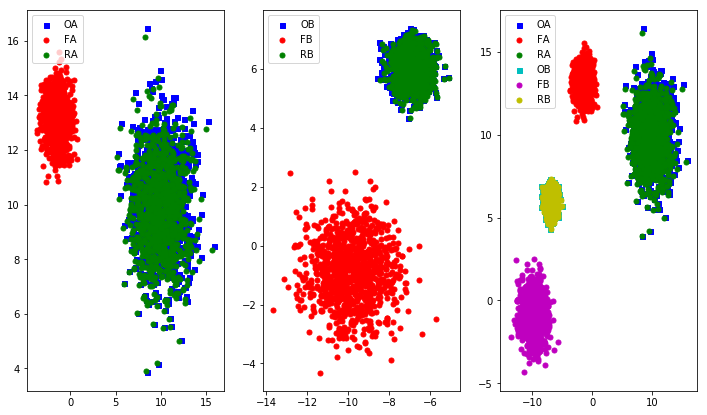

[Epoch 50/1000] [Batch 248/250] [D loss: 0.669646, acc:  68%] 
  [Translation AB Dist: 1.711503 BA Dist: 5.821360 Min AB Dist: 1.433941 Max AB: 1.942835 Min BA: 3.869767Max BA: 7.115872] 
 [G loss: 1.872492, adv: 0.731112, recon: 0.105361, id: 14.353905] time: 0:00:49.163402 
[Fake A Mean: (9, 9) Fake A Var: 0 A Mean: (9, 10) A Var: 2 ]
[Fake B Mean: (-6, 9) Fake B Var: 0 B Mean: (-7, 5) B Var: 0 ]


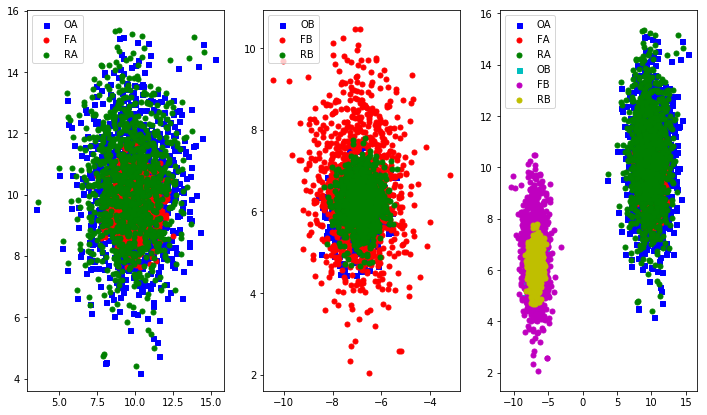

[Epoch 100/1000] [Batch 248/250] [D loss: 0.643369, acc:  75%] 
  [Translation AB Dist: 1.409033 BA Dist: 5.663689 Min AB Dist: 1.102562 Max AB: 1.721942 Min BA: 3.740675Max BA: 6.947492] 
 [G loss: 2.130729, adv: 0.783571, recon: 0.170013, id: 16.496550] time: 0:01:32.742721 
[Fake A Mean: (10, 9) Fake A Var: 0 A Mean: (10, 9) A Var: 2 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-7, 5) B Var: 0 ]


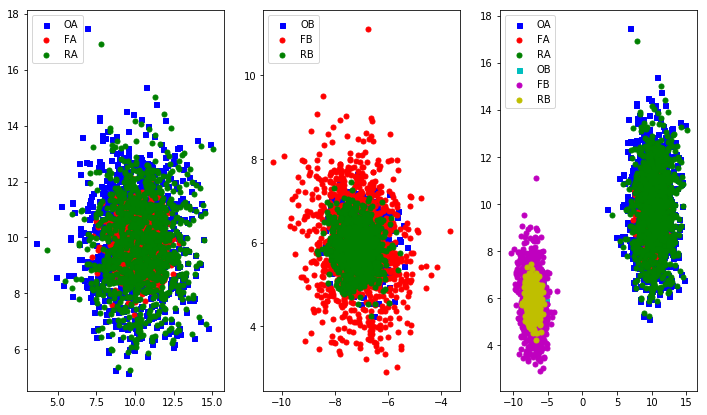

[Epoch 150/1000] [Batch 248/250] [D loss: 0.640358, acc:  75%] 
  [Translation AB Dist: 1.231040 BA Dist: 5.597396 Min AB Dist: 1.061068 Max AB: 1.374014 Min BA: 3.727331Max BA: 6.887891] 
 [G loss: 2.102567, adv: 0.772398, recon: 0.153374, id: 19.412891] time: 0:02:16.598204 
[Fake A Mean: (10, 10) Fake A Var: 0 A Mean: (10, 9) A Var: 2 ]
[Fake B Mean: (-6, 10) Fake B Var: 0 B Mean: (-6, 5) B Var: 0 ]


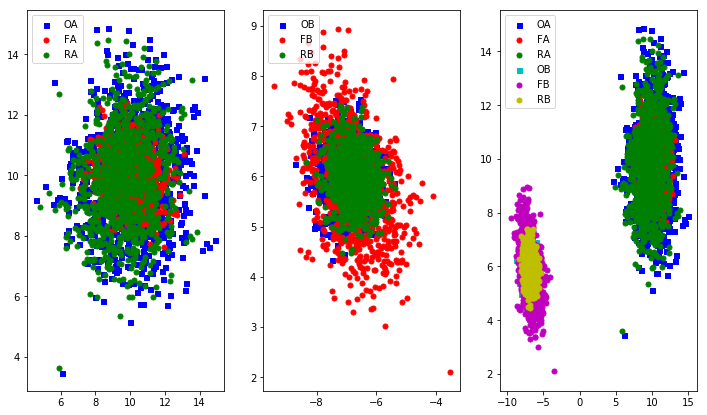

[Epoch 200/1000] [Batch 248/250] [D loss: 0.644572, acc:  75%] 
  [Translation AB Dist: 1.215358 BA Dist: 5.559624 Min AB Dist: 1.060079 Max AB: 1.350378 Min BA: 3.670841Max BA: 6.815154] 
 [G loss: 2.172343, adv: 0.778037, recon: 0.177302, id: 20.718256] time: 0:03:00.071677 
[Fake A Mean: (9, 10) Fake A Var: 1 A Mean: (9, 9) A Var: 2 ]
[Fake B Mean: (-6, 10) Fake B Var: 0 B Mean: (-7, 6) B Var: 0 ]


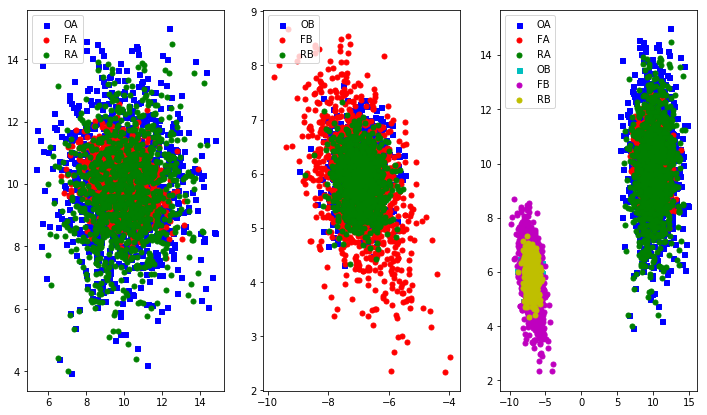

[Epoch 250/1000] [Batch 248/250] [D loss: 0.638570, acc:  75%] 
  [Translation AB Dist: 1.069965 BA Dist: 5.473201 Min AB Dist: 0.853867 Max AB: 1.237216 Min BA: 3.581625Max BA: 6.712002] 
 [G loss: 2.331293, adv: 0.796782, recon: 0.235643, id: 21.435520] time: 0:03:43.237067 
[Fake A Mean: (9, 10) Fake A Var: 1 A Mean: (10, 10) A Var: 2 ]
[Fake B Mean: (-7, 10) Fake B Var: 0 B Mean: (-6, 5) B Var: 0 ]


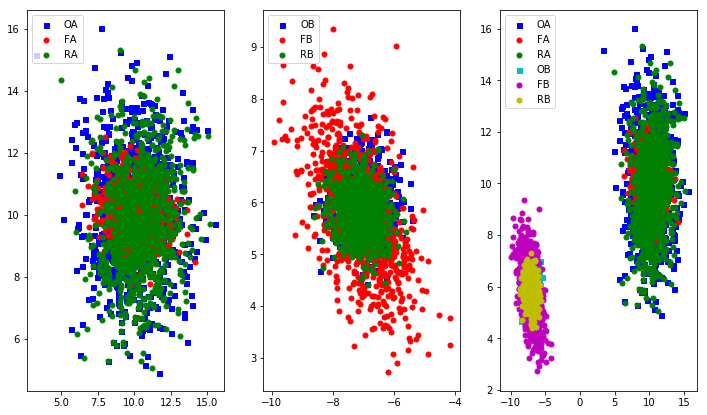

[Epoch 300/1000] [Batch 248/250] [D loss: 0.635133, acc:  75%] 
  [Translation AB Dist: 1.103768 BA Dist: 5.521693 Min AB Dist: 1.026730 Max AB: 1.311257 Min BA: 3.655760Max BA: 6.791604] 
 [G loss: 2.553396, adv: 0.805959, recon: 0.336893, id: 21.755516] time: 0:04:26.143774 
[Fake A Mean: (9, 10) Fake A Var: 1 A Mean: (10, 9) A Var: 2 ]
[Fake B Mean: (-6, 10) Fake B Var: 0 B Mean: (-7, 6) B Var: 0 ]


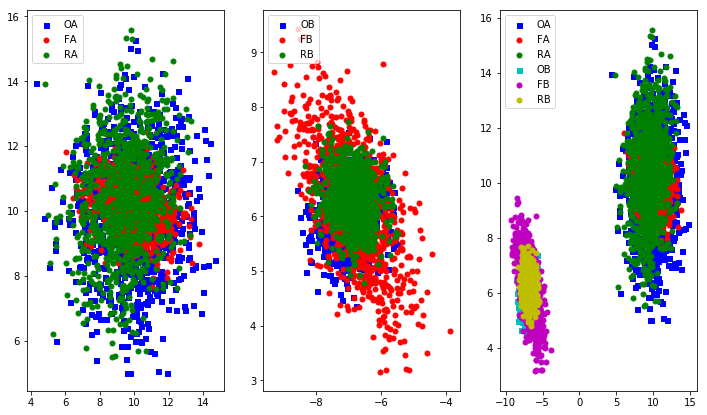

[Epoch 350/1000] [Batch 248/250] [D loss: 0.636912, acc:  75%] 
  [Translation AB Dist: 1.110187 BA Dist: 5.502302 Min AB Dist: 0.907391 Max AB: 1.235736 Min BA: 3.626858Max BA: 6.752663] 
 [G loss: 2.382659, adv: 0.809152, recon: 0.248091, id: 21.901182] time: 0:05:08.948168 
[Fake A Mean: (9, 10) Fake A Var: 1 A Mean: (10, 10) A Var: 2 ]
[Fake B Mean: (-7, 10) Fake B Var: 0 B Mean: (-6, 6) B Var: 0 ]


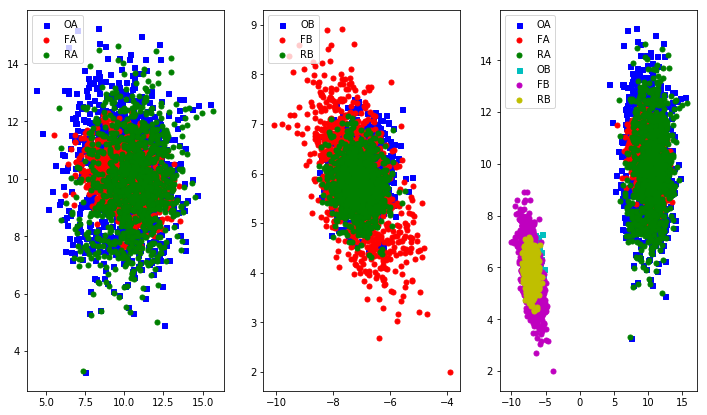

[Epoch 400/1000] [Batch 248/250] [D loss: 0.649093, acc:  75%] 
  [Translation AB Dist: 1.017507 BA Dist: 5.389769 Min AB Dist: 0.819476 Max AB: 1.151953 Min BA: 3.490963Max BA: 6.577126] 
 [G loss: 2.396838, adv: 0.779346, recon: 0.284978, id: 21.893694] time: 0:05:52.025229 
[Fake A Mean: (9, 10) Fake A Var: 1 A Mean: (9, 10) A Var: 3 ]
[Fake B Mean: (-7, 10) Fake B Var: 0 B Mean: (-6, 5) B Var: 0 ]


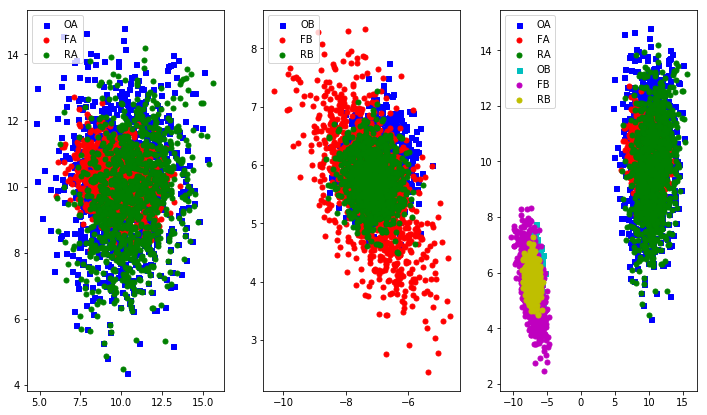

In [ ]:
gan_default_relu= CycleGANRL(data_A, data_B)
gan_default_relu.train(epochs=1000, batch_size=4, sample_interval=50)

Increased the capacity of the generator by increasing the width of the layers that already exist 

In [8]:
class WiderCycleGANRL():
    def __init__(self, data_A, data_B, lr_G=0.001, lr_D=0.0005, lambda_cycle=1, 
                 disclossconst=1, idloss=0.01, disclossfunc='binary_crossentropy', width=4, seed=997):
        
        #
        self.data_shape=(2,)
        self.data_dim=2
        self.disclossconst=disclossconst
        self.idloss=idloss
        self.disclossfunc=disclossfunc
        self.seed=seed
        self.width=width

        # Loss weights
        ##################################
        # First change: set cycle-consistency weight to unit.
        # Could probably do the same to identity-loss weight
        # without much change, but the lambda_cycle weight
        # did seem to have an effect
        ##################################
        self.lambda_cycle = lambda_cycle                    # Cycle-consistency loss
        self.lambda_id = self.idloss * self.lambda_cycle    # Identity loss

        ##################################
        # Second change: optimizers
        # Start with SGD on easy data, then consider using Adam/RMSprop when you
        # get a feel for how training will go. The former is simpler and more
        # predictable, the latter can be erratic if you don't understand how to
        # set the hyperparameters.
        #
        # And then: different learning rates for generator and discriminator.
        # I'm suspicious of anyone who doesn't do this unless the discriminator
        # is non-sigmoid.
        # I'm suspicious of non-sigmoid discriminators except Wasserstein GAN.
        ##################################
        optimizer_G = SGD(lr=lr_G)
        optimizer_D = SGD(lr=lr_D)

        ##################################
        # Third change: discriminator loss
        # The original CycleGAN authors used MSE instead of BCE.
        # They cited some paper I've never heard of which claimed
        # that it encourages stability.
        # This sounds like a poor-man's Wasserstein GAN without
        # any of the analysis to back it up, FWIW.
        # Switched back to BCE because we know it works on
        # other types of GANs.
        #
        # ALSO: The discriminator's output layer had a sigmoid
        # activation, which doesn't make sense with MSE.
        # If you look in the original cyclegan.py, the
        # discriminator's final layer was the default activation,
        # which is linear. This makes more sense with MSE.
        # I also tried leaving MSE loss, and making the discriminator's
        # last activation linear, but that didn't work as well.
        ##################################
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss=self.disclossfunc,
            optimizer=optimizer_D,
            metrics=['accuracy'])
        self.d_B.compile(loss=self.disclossfunc,
            optimizer=optimizer_D,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generators
        #-------------------------
        np.random.seed(self.seed)
        # Build the generators
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # Input instances from both domains
        datum_A = Input(shape=self.data_shape)
        datum_B = Input(shape=self.data_shape)


        #Is this going to work the way I have it here
        #or should I be taking something from a batch?
        # Translate images to the other domain
        fake_B = self.g_AB(datum_A)
        fake_A = self.g_BA(datum_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        datum_A_id = self.g_BA(datum_A)
        datum_B_id = self.g_AB(datum_B)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        ##################################
        # Third change (part two): consistent switch to BCE
        # for all discriminator losses
        ##################################
        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[datum_A, datum_B],
                              outputs=[ valid_A, valid_B,
                                        reconstr_A, reconstr_B,
                                        datum_A_id, datum_B_id ])
        self.combined.compile(loss=[self.disclossfunc, self.disclossfunc,
                                    'mae', 'mae',
                                    'mae', 'mae'],
                            loss_weights=[  self.disclossconst, self.disclossconst,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id ],
                            optimizer=optimizer_G)

    

    def build_generator(self):
        """
        Simple MLP generator for the MoG unrolled GAN toy experiment
        """

        gen_input = Input(shape=(self.data_dim,), name="generator_input")

        ##################################
        # Fourth change: made this tanh instead of relu.
        # I suspect the important thing is to have similar activations
        # in generator and discriminator, but who knows.
        # Could also try relu in both, but I would use LeakyReLU.
        ##################################
        x = Dense(2*self.data_dim)(gen_input)
        x = LeakyReLU(alpha=0.2)(x)
     #     for i in range(2):
        x = Dense(self.width*self.data_dim)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dense(2)(gen_input)
        

        generator_model = Model(inputs=[gen_input], outputs=[x])
        #visualize_model(generator_model)

        return generator_model

#        
    def build_discriminator(self):

        """
        Simple MLP discriminator for the MoG unrolled GAN toy experiment
        """

        disc_input = Input(shape=(2,), name="discriminator_input")

        x = Dense(2*self.data_dim)(disc_input)
        x = LeakyReLU(alpha=0.2)(x)
    #     for i in range(2):
        x = Dense(2*self.data_dim)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dense(1, activation="sigmoid")(x)

        discriminator_model = Model(inputs=[disc_input], outputs=[x])
        #visualize_model(discriminator_model)

        #is there a difference between what this returns and the original cycelgan does?
        return discriminator_model

    
    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()
        np.random.seed(self.seed)

        # Adversarial loss ground truths
        valid = np.ones((batch_size,)) #+ self.disc_patch)
        fake = np.zeros((batch_size,)) #+ self.disc_patch)
#         self.g_AB.summary()
#         self.g_BA.summary()
#         self.d_A.summary()
#         self.d_B.summary()
        self.n_batches = int(min(len(data_A), len(data_B)) / batch_size)
        #total_samples = self.n_batches * batch_size
        for epoch in range(epochs):
            for i in range(self.n_batches-1):
                #randomly shuffle data?
                
                #take the corresponding "Batch size" number of elements
                batch_A = data_A[i*batch_size:(i+1)*batch_size]
                batch_B = data_B[i*batch_size:(i+1)*batch_size]
                #put them through this thing
                
                
                # ----------------------
                #  Train Discriminators
                # ----------------------
               # print(imgs_A.shape)

                # Translate images to opposite domain
                fake_B = self.g_AB.predict(batch_A)
                fake_A = self.g_BA.predict(batch_B)
                #print(fake_A.shape)
                #print(fake_B.shape)
                # Train the discriminators (original images = real / translated = Fake)
                dA_loss_real = self.d_A.train_on_batch(batch_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(batch_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # Total disciminator loss
                d_loss = 0.5 * np.add(dA_loss, dB_loss)


                # ------------------
                #  Train Generators
                # ------------------

                # Train the generators
                g_loss = self.combined.train_on_batch([batch_A, batch_B],
                                                        [valid, valid,
                                                        batch_A, batch_B,
                                                        batch_A, batch_B])

                elapsed_time = datetime.datetime.now() - start_time
                
                #question: when you call predict on a generator, does it return elements
                #in the same order you send them in?
                #because i'm assuming here that fake_a[i] will correspond to batch_b[i]. IS this true?
                #until I know, I'll stick to batch size 1 always
                translation_acc_AB=np.asarray([])
                translation_acc_BA=np.asarray([])
                translation_max_BA=np.asarray([])
                translation_min_AB=np.asarray([])
                #computes the average euclidean distance between a-->translated->b, 
                #and the corresponding point that cyclegan generated 
                translation_acc_AB=np.append(translation_acc_AB, (np.asarray(
                    [scipy.spatial.distance.euclidean(
                        (translate_pt(a, (10,10), 3, (-7,6), .25)), bf) for (a,bf) in zip(batch_A, fake_B) ]).mean()))
                translation_acc_BA=np.append(translation_acc_AB, (np.asarray(
                    [scipy.spatial.distance.euclidean(
                        (translate_pt(b, (-7,6), .25, (10,10), 3)), af) for (b,af) in zip(batch_B, fake_A) ]).mean()))
                
                #computes the minimum euclidean distance between a-->translated->b, 
                #and the corresponding point that cyclegan generated 
                translation_min_AB=np.append(translation_acc_AB, (np.asarray(
                    [scipy.spatial.distance.euclidean(
                        (translate_pt(a, (10,10), 3, (-7,6), .25)), bf) for (a,bf) in zip(batch_A, fake_B) ]).min()))
                translation_min_BA=np.append(translation_acc_AB, (np.asarray(
                    [scipy.spatial.distance.euclidean(
                        (translate_pt(b, (-7,6), .25, (10,10), 3)), af) for (b,af) in zip(batch_B, fake_A) ]).min()))
                
                #computes the maximum euclidean distance between a-->translated->b, 
                #and the corresponding point that cyclegan generated 
                translation_max_AB=np.append(translation_acc_AB, (np.asarray(
                    [scipy.spatial.distance.euclidean(
                        (translate_pt(a, (10,10), 3, (-7,6), .25)), bf) for (a,bf) in zip(batch_A, fake_B) ]).max()))
                translation_max_BA=np.append(translation_acc_AB, (np.asarray(
                    [scipy.spatial.distance.euclidean(
                        (translate_pt(b, (-7,6), .25, (10,10), 3)), af) for (b,af) in zip(batch_B, fake_A) ]).max()))
    
                # Plot the progress
            if epoch % sample_interval == 0:
                print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] \n  [Translation AB Dist: %f BA Dist: %f Min AB Dist: %f Max AB: %f Min BA: %fMax BA: %f] \n [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                                                                        % ( epoch, epochs,
                                                                            i, self.n_batches,
                                                                            d_loss[0], 100*d_loss[1],
                                                                            np.asarray(translation_acc_AB).mean(),
                                                                            np.asarray(translation_acc_BA).mean(),
                                                                            np.asarray(translation_min_AB).mean(),
                                                                            np.asarray(translation_max_AB).mean(),
                                                                            np.asarray(translation_min_BA).mean(),
                                                                            np.asarray(translation_max_BA).mean(),
                                                                            g_loss[0], 
                                                                            np.mean(g_loss[1:3]),
                                                                            np.mean(g_loss[3:5]),
                                                                            np.mean(g_loss[5:6]),
                                                                            elapsed_time))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_data(epoch, i)

    def sample_data(self, epoch, batch_i):
       # r, c = 2, 3

        orig2, pic_data_A, pic_data_B= gen_data((10,10), 3, (-7,6), .25, 1000)
        
    
        # Translate images to the other domain
        fake_B = self.g_AB.predict(pic_data_A)
        fake_A = self.g_BA.predict(pic_data_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)
        
        #give the translation accuracy for a random element
        #I'm not doing the average because I'm not sure the fake and real correspond 1-1
        #I can change this later if I think they do
        num=np.random.randint(len(fake_A[0]))
        trans_acc_AB= np.asarray(
                    [scipy.spatial.distance.euclidean((translate_pt(pic_data_A[num])), fake_B[num])])
        trans_acc_BA= np.asarray(
                    [scipy.spatial.distance.euclidean((translate_pt(pic_data_B[num])), fake_A[num])])
#         translation_acc_AB.append= np.asarray(
#                     [scipy.spatial.distance.euclidean((translate_pt(a)), bf) for (a,bf) in zip(batch_A, fake_B) ]).mean()
#         translation_acc_BA.append= np.asarray(
#                     [scipy.spatial.distance.euclidean((translate_pt(b)), af) for (b,af) in zip(batch_B, fake_A) ]).mean()
    
        #print("[Trans Dist AB: %d Dist: %d]" \ %(trans_acc_AB, trans_acc_BA))
        
        
        #means and variances
        #(are vars computed right? I did it along one axis because I think they're the same on both) 
        #for real and generated distributions
        fakeA_mean=[np.mean(np.asarray(fake_A[:,0])), np.mean(np.asarray(fake_A[:,1]))]
        fakeA_var=np.asarray(fake_A[:,0]).var()
        realA_mean=[np.mean(np.asarray(pic_data_A[:,0])), np.mean(np.asarray(pic_data_A[:,1]))]
        realA_var=np.asarray(pic_data_A[:,0]).var()
        print("[Fake A Mean: (%d, %d) Fake A Var: %d A Mean: (%d, %d) A Var: %d ]"  
              %(fakeA_mean[0], fakeA_mean[1], fakeA_var, realA_mean[0], realA_mean[1], realA_var))
        
        fakeB_mean=[np.mean(np.asarray(fake_B[:,0])), np.mean(np.asarray(fake_A[:,1]))]
        fakeB_var=np.asarray(fake_B[:,0]).var()
        realB_mean=[np.mean(np.asarray(pic_data_B[:,0])), np.mean(np.asarray(pic_data_B[:,1]))]
        realB_var=np.asarray(pic_data_B[:,0]).var()
        print("[Fake B Mean: (%d, %d) Fake B Var: %d B Mean: (%d, %d) B Var: %d ]"  
              %(fakeB_mean[0], fakeB_mean[1], fakeB_var, realB_mean[0], realB_mean[1], realB_var))
        
        fig = plt.figure(figsize=(12,7))
        ax1 = fig.add_subplot(131)

        ax1.scatter(pic_data_A[:, 0], pic_data_A[:,1], s=25, c='b', marker="s", label='OA')
        ax1.scatter(fake_A[:,0], fake_A[:,1], c='r', s=25, marker="o", label='FA')
        ax1.scatter(reconstr_A[:,0], reconstr_A[:,1], s=25, c='g', marker="o", label='RA')
        plt.legend(loc='upper left');
        
        ax2=fig.add_subplot(132)
        ax2.scatter(pic_data_B[:, 0], pic_data_B[:,1], s=25, c='b', marker="s", label='OB')
        ax2.scatter(fake_B[:,0], fake_B[:,1], s=25, c='r', marker="o", label='FB')
        ax2.scatter(reconstr_B[:,0], reconstr_B[:,1], s=25, c='g', marker="o", label='RB')
        plt.legend(loc='upper left');
        
        ax3=fig.add_subplot(133)
        ax3.scatter(pic_data_A[:, 0], pic_data_A[:,1], s=25, c='b', marker="s", label='OA')
        ax3.scatter(fake_A[:,0], fake_A[:,1], c='r', s=25, marker="o", label='FA')
        ax3.scatter(reconstr_A[:,0], reconstr_A[:,1], s=25, c='g', marker="o", label='RA')
        ax3.scatter(pic_data_B[:, 0], pic_data_B[:,1], s=25, c='c', marker="s", label='OB')
        ax3.scatter(fake_B[:,0], fake_B[:,1], s=25, c='m', marker="o", label='FB')
        ax3.scatter(reconstr_B[:,0], reconstr_B[:,1], s=25, c='y', marker="o", label='RB')
        plt.legend(loc='upper left');
        
        plt.show()
        plt.clf()
        fig.savefig("images/%d_%d.png" % (epoch, batch_i))
        plt.close()

/home/emilybla/miniconda2/envs/py3keras/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/emilybla/miniconda2/envs/py3keras/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/emilybla/miniconda2/envs/py3keras/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[Epoch 0/1000] [Batch 248/250] [D loss: 0.554533, acc:  68%] 
  [Translation AB Dist: 8.421287 BA Dist: 10.491321 Min AB Dist: 7.929031 Max AB: 8.961831 Min BA: 7.704925Max BA: 13.048357] 
 [G loss: 2.004217, adv: 0.709928, recon: 0.171418, id: 20.912828] time: 0:00:04.962536 
[Fake A Mean: (-2, 12) Fake A Var: 0 A Mean: (10, 10) A Var: 2 ]
[Fake B Mean: (-10, 12) Fake B Var: 1 B Mean: (-7, 6) B Var: 0 ]


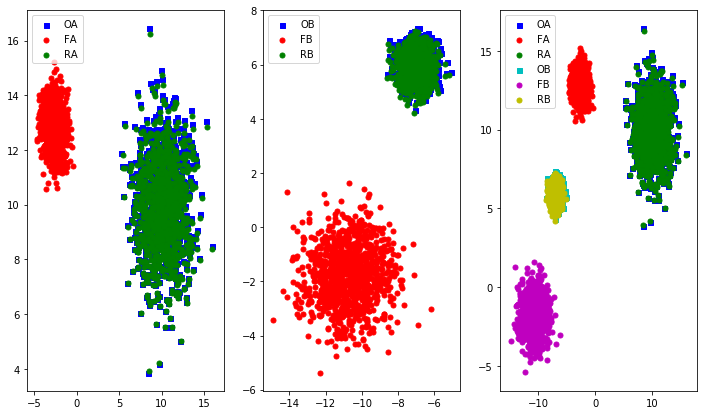

[Epoch 50/1000] [Batch 248/250] [D loss: 0.692294, acc:  56%] 
  [Translation AB Dist: 5.842555 BA Dist: 7.007076 Min AB Dist: 4.317066 Max AB: 6.811826 Min BA: 3.651621Max BA: 9.787028] 
 [G loss: 1.967321, adv: 0.697080, recon: 0.195058, id: 13.015862] time: 0:00:35.790998 
[Fake A Mean: (6, 6) Fake A Var: 0 A Mean: (9, 10) A Var: 2 ]
[Fake B Mean: (-11, 6) Fake B Var: 2 B Mean: (-7, 5) B Var: 0 ]


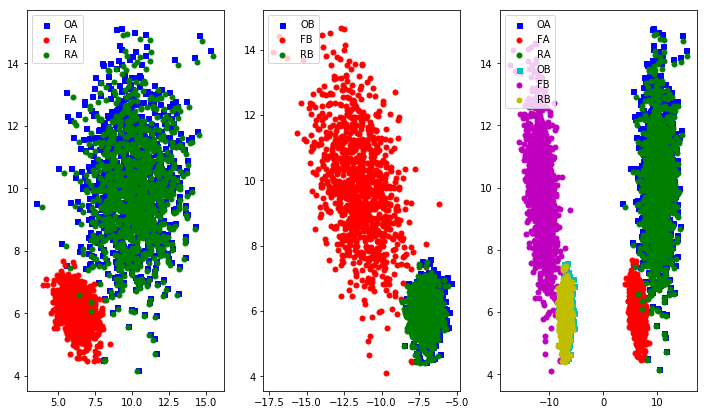

In [ ]:
gan_4_width_RL = WiderCycleGANRL(data_A, data_B)
gan_4_width_RL.train(epochs=1000, batch_size=4, sample_interval=50)

In [ ]:
gan_8_width_RL = WiderCycleGANRL(data_A, data_B, width=8)
gan_8_width_RL.train(epochs=1000, batch_size=4, sample_interval=50)

Increased the capacity of the generator by making it deeper

In [ ]:
class DeeperCycleGANRL():
    def __init__(self, data_A, data_B, lr_G=0.001, lr_D=0.0005, lambda_cycle=1, 
                 disclossconst=1, idloss=0.01, disclossfunc='binary_crossentropy', seed=997):
        
        #
        self.data_shape=(2,)
        self.data_dim=2
        self.disclossconst=disclossconst
        self.idloss=idloss
        self.disclossfunc=disclossfunc
        self.seed=seed

        # Loss weights
        ##################################
        # First change: set cycle-consistency weight to unit.
        # Could probably do the same to identity-loss weight
        # without much change, but the lambda_cycle weight
        # did seem to have an effect
        ##################################
        self.lambda_cycle = lambda_cycle                    # Cycle-consistency loss
        self.lambda_id = self.idloss * self.lambda_cycle    # Identity loss

        ##################################
        # Second change: optimizers
        # Start with SGD on easy data, then consider using Adam/RMSprop when you
        # get a feel for how training will go. The former is simpler and more
        # predictable, the latter can be erratic if you don't understand how to
        # set the hyperparameters.
        #
        # And then: different learning rates for generator and discriminator.
        # I'm suspicious of anyone who doesn't do this unless the discriminator
        # is non-sigmoid.
        # I'm suspicious of non-sigmoid discriminators except Wasserstein GAN.
        ##################################
        optimizer_G = SGD(lr=lr_G)
        optimizer_D = SGD(lr=lr_D)

        ##################################
        # Third change: discriminator loss
        # The original CycleGAN authors used MSE instead of BCE.
        # They cited some paper I've never heard of which claimed
        # that it encourages stability.
        # This sounds like a poor-man's Wasserstein GAN without
        # any of the analysis to back it up, FWIW.
        # Switched back to BCE because we know it works on
        # other types of GANs.
        #
        # ALSO: The discriminator's output layer had a sigmoid
        # activation, which doesn't make sense with MSE.
        # If you look in the original cyclegan.py, the
        # discriminator's final layer was the default activation,
        # which is linear. This makes more sense with MSE.
        # I also tried leaving MSE loss, and making the discriminator's
        # last activation linear, but that didn't work as well.
        ##################################
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss=self.disclossfunc,
            optimizer=optimizer_D,
            metrics=['accuracy'])
        self.d_B.compile(loss=self.disclossfunc,
            optimizer=optimizer_D,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generators
        #-------------------------
        np.random.seed(self.seed)
        # Build the generators
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # Input instances from both domains
        datum_A = Input(shape=self.data_shape)
        datum_B = Input(shape=self.data_shape)


        #Is this going to work the way I have it here
        #or should I be taking something from a batch?
        # Translate images to the other domain
        fake_B = self.g_AB(datum_A)
        fake_A = self.g_BA(datum_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        datum_A_id = self.g_BA(datum_A)
        datum_B_id = self.g_AB(datum_B)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        ##################################
        # Third change (part two): consistent switch to BCE
        # for all discriminator losses
        ##################################
        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[datum_A, datum_B],
                              outputs=[ valid_A, valid_B,
                                        reconstr_A, reconstr_B,
                                        datum_A_id, datum_B_id ])
        self.combined.compile(loss=[self.disclossfunc, self.disclossfunc,
                                    'mae', 'mae',
                                    'mae', 'mae'],
                            loss_weights=[  self.disclossconst, self.disclossconst,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id ],
                            optimizer=optimizer_G)

    

    def build_generator(self):
        """
        Simple MLP generator for the MoG unrolled GAN toy experiment
        """

        gen_input = Input(shape=(self.data_dim,), name="generator_input")

        ##################################
        # Fourth change: made this tanh instead of relu.
        # I suspect the important thing is to have similar activations
        # in generator and discriminator, but who knows.
        # Could also try relu in both, but I would use LeakyReLU.
        ##################################
        x = Dense(2*self.data_dim)(gen_input)
        x = LeakyReLU(alpha=0.2)(x)
     #     for i in range(2):
        x = Dense(4*self.data_dim)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dense(4*self.data_dim)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dense(2)(gen_input)
        

        generator_model = Model(inputs=[gen_input], outputs=[x])
        #visualize_model(generator_model)

        return generator_model

#        
    def build_discriminator(self):

        """
        Simple MLP discriminator for the MoG unrolled GAN toy experiment
        """

        disc_input = Input(shape=(2,), name="discriminator_input")

        x = Dense(2*self.data_dim)(disc_input)
        x = LeakyReLU(alpha=0.2)(x)
    #     for i in range(2):
        x = Dense(2*self.data_dim)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dense(1, activation="sigmoid")(x)

        discriminator_model = Model(inputs=[disc_input], outputs=[x])
        #visualize_model(discriminator_model)

        #is there a difference between what this returns and the original cycelgan does?
        return discriminator_model

    
    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()
        np.random.seed(self.seed)

        # Adversarial loss ground truths
        valid = np.ones((batch_size,)) #+ self.disc_patch)
        fake = np.zeros((batch_size,)) #+ self.disc_patch)
#         self.g_AB.summary()
#         self.g_BA.summary()
#         self.d_A.summary()
#         self.d_B.summary()
        self.n_batches = int(min(len(data_A), len(data_B)) / batch_size)
        #total_samples = self.n_batches * batch_size
        for epoch in range(epochs):
            for i in range(self.n_batches-1):
                #randomly shuffle data?
                
                #take the corresponding "Batch size" number of elements
                batch_A = data_A[i*batch_size:(i+1)*batch_size]
                batch_B = data_B[i*batch_size:(i+1)*batch_size]
                #put them through this thing
                
                
                # ----------------------
                #  Train Discriminators
                # ----------------------
               # print(imgs_A.shape)

                # Translate images to opposite domain
                fake_B = self.g_AB.predict(batch_A)
                fake_A = self.g_BA.predict(batch_B)
                #print(fake_A.shape)
                #print(fake_B.shape)
                # Train the discriminators (original images = real / translated = Fake)
                dA_loss_real = self.d_A.train_on_batch(batch_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(batch_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # Total disciminator loss
                d_loss = 0.5 * np.add(dA_loss, dB_loss)


                # ------------------
                #  Train Generators
                # ------------------

                # Train the generators
                g_loss = self.combined.train_on_batch([batch_A, batch_B],
                                                        [valid, valid,
                                                        batch_A, batch_B,
                                                        batch_A, batch_B])

                elapsed_time = datetime.datetime.now() - start_time
                
                #question: when you call predict on a generator, does it return elements
                #in the same order you send them in?
                #because i'm assuming here that fake_a[i] will correspond to batch_b[i]. IS this true?
                #until I know, I'll stick to batch size 1 always
                translation_acc_AB=np.asarray([])
                translation_acc_BA=np.asarray([])
                translation_max_BA=np.asarray([])
                translation_min_AB=np.asarray([])
                #computes the average euclidean distance between a-->translated->b, 
                #and the corresponding point that cyclegan generated 
                translation_acc_AB=np.append(translation_acc_AB, (np.asarray(
                    [scipy.spatial.distance.euclidean(
                        (translate_pt(a, (10,10), 3, (-7,6), .25)), bf) for (a,bf) in zip(batch_A, fake_B) ]).mean()))
                translation_acc_BA=np.append(translation_acc_AB, (np.asarray(
                    [scipy.spatial.distance.euclidean(
                        (translate_pt(b, (-7,6), .25, (10,10), 3)), af) for (b,af) in zip(batch_B, fake_A) ]).mean()))
                
                #computes the minimum euclidean distance between a-->translated->b, 
                #and the corresponding point that cyclegan generated 
                translation_min_AB=np.append(translation_acc_AB, (np.asarray(
                    [scipy.spatial.distance.euclidean(
                        (translate_pt(a, (10,10), 3, (-7,6), .25)), bf) for (a,bf) in zip(batch_A, fake_B) ]).min()))
                translation_min_BA=np.append(translation_acc_AB, (np.asarray(
                    [scipy.spatial.distance.euclidean(
                        (translate_pt(b, (-7,6), .25, (10,10), 3)), af) for (b,af) in zip(batch_B, fake_A) ]).min()))
                
                #computes the maximum euclidean distance between a-->translated->b, 
                #and the corresponding point that cyclegan generated 
                translation_max_AB=np.append(translation_acc_AB, (np.asarray(
                    [scipy.spatial.distance.euclidean(
                        (translate_pt(a, (10,10), 3, (-7,6), .25)), bf) for (a,bf) in zip(batch_A, fake_B) ]).max()))
                translation_max_BA=np.append(translation_acc_AB, (np.asarray(
                    [scipy.spatial.distance.euclidean(
                        (translate_pt(b, (-7,6), .25, (10,10), 3)), af) for (b,af) in zip(batch_B, fake_A) ]).max()))
    
                # Plot the progress
            if epoch % sample_interval == 0:
                print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] \n  [Translation AB Dist: %f BA Dist: %f Min AB Dist: %f Max AB: %f Min BA: %fMax BA: %f] \n [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                                                                        % ( epoch, epochs,
                                                                            i, self.n_batches,
                                                                            d_loss[0], 100*d_loss[1],
                                                                            np.asarray(translation_acc_AB).mean(),
                                                                            np.asarray(translation_acc_BA).mean(),
                                                                            np.asarray(translation_min_AB).mean(),
                                                                            np.asarray(translation_max_AB).mean(),
                                                                            np.asarray(translation_min_BA).mean(),
                                                                            np.asarray(translation_max_BA).mean(),
                                                                            g_loss[0], 
                                                                            np.mean(g_loss[1:3]),
                                                                            np.mean(g_loss[3:5]),
                                                                            np.mean(g_loss[5:6]),
                                                                            elapsed_time))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_data(epoch, i)

    def sample_data(self, epoch, batch_i):
       # r, c = 2, 3

        orig2, pic_data_A, pic_data_B= gen_data((10,10), 3, (-7,6), .25, 1000)
        
    
        # Translate images to the other domain
        fake_B = self.g_AB.predict(pic_data_A)
        fake_A = self.g_BA.predict(pic_data_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)
        
        #give the translation accuracy for a random element
        #I'm not doing the average because I'm not sure the fake and real correspond 1-1
        #I can change this later if I think they do
        num=np.random.randint(len(fake_A[0]))
        trans_acc_AB= np.asarray(
                    [scipy.spatial.distance.euclidean((translate_pt(pic_data_A[num])), fake_B[num])])
        trans_acc_BA= np.asarray(
                    [scipy.spatial.distance.euclidean((translate_pt(pic_data_B[num])), fake_A[num])])
#         translation_acc_AB.append= np.asarray(
#                     [scipy.spatial.distance.euclidean((translate_pt(a)), bf) for (a,bf) in zip(batch_A, fake_B) ]).mean()
#         translation_acc_BA.append= np.asarray(
#                     [scipy.spatial.distance.euclidean((translate_pt(b)), af) for (b,af) in zip(batch_B, fake_A) ]).mean()
    
        #print("[Trans Dist AB: %d Dist: %d]" \ %(trans_acc_AB, trans_acc_BA))
        
        
        #means and variances
        #(are vars computed right? I did it along one axis because I think they're the same on both) 
        #for real and generated distributions
        fakeA_mean=[np.mean(np.asarray(fake_A[:,0])), np.mean(np.asarray(fake_A[:,1]))]
        fakeA_var=np.asarray(fake_A[:,0]).var()
        realA_mean=[np.mean(np.asarray(pic_data_A[:,0])), np.mean(np.asarray(pic_data_A[:,1]))]
        realA_var=np.asarray(pic_data_A[:,0]).var()
        print("[Fake A Mean: (%d, %d) Fake A Var: %d A Mean: (%d, %d) A Var: %d ]"  
              %(fakeA_mean[0], fakeA_mean[1], fakeA_var, realA_mean[0], realA_mean[1], realA_var))
        
        fakeB_mean=[np.mean(np.asarray(fake_B[:,0])), np.mean(np.asarray(fake_A[:,1]))]
        fakeB_var=np.asarray(fake_B[:,0]).var()
        realB_mean=[np.mean(np.asarray(pic_data_B[:,0])), np.mean(np.asarray(pic_data_B[:,1]))]
        realB_var=np.asarray(pic_data_B[:,0]).var()
        print("[Fake B Mean: (%d, %d) Fake B Var: %d B Mean: (%d, %d) B Var: %d ]"  
              %(fakeB_mean[0], fakeB_mean[1], fakeB_var, realB_mean[0], realB_mean[1], realB_var))
        
        fig = plt.figure(figsize=(12,7))
        ax1 = fig.add_subplot(131)

        ax1.scatter(pic_data_A[:, 0], pic_data_A[:,1], s=25, c='b', marker="s", label='OA')
        ax1.scatter(fake_A[:,0], fake_A[:,1], c='r', s=25, marker="o", label='FA')
        ax1.scatter(reconstr_A[:,0], reconstr_A[:,1], s=25, c='g', marker="o", label='RA')
        plt.legend(loc='upper left');
        
        ax2=fig.add_subplot(132)
        ax2.scatter(pic_data_B[:, 0], pic_data_B[:,1], s=25, c='b', marker="s", label='OB')
        ax2.scatter(fake_B[:,0], fake_B[:,1], s=25, c='r', marker="o", label='FB')
        ax2.scatter(reconstr_B[:,0], reconstr_B[:,1], s=25, c='g', marker="o", label='RB')
        plt.legend(loc='upper left');
        
        ax3=fig.add_subplot(133)
        ax3.scatter(pic_data_A[:, 0], pic_data_A[:,1], s=25, c='b', marker="s", label='OA')
        ax3.scatter(fake_A[:,0], fake_A[:,1], c='r', s=25, marker="o", label='FA')
        ax3.scatter(reconstr_A[:,0], reconstr_A[:,1], s=25, c='g', marker="o", label='RA')
        ax3.scatter(pic_data_B[:, 0], pic_data_B[:,1], s=25, c='c', marker="s", label='OB')
        ax3.scatter(fake_B[:,0], fake_B[:,1], s=25, c='m', marker="o", label='FB')
        ax3.scatter(reconstr_B[:,0], reconstr_B[:,1], s=25, c='y', marker="o", label='RB')
        plt.legend(loc='upper left');
        
        plt.show()
        plt.clf()
        fig.savefig("images/%d_%d.png" % (epoch, batch_i))
        plt.close()

In [ ]:
gan_3_depthRL = DeeperCycleGANRL(data_A, data_B)
gan_3_depthRL.train(epochs=1000, batch_size=4, sample_interval=50)

In [ ]:
class LinearCycleGANRL():
    def __init__(self, data_A, data_B, lr_G=0.001, lr_D=0.0005, lambda_cycle=1, 
                 disclossconst=1, idloss=0.01, disclossfunc='binary_crossentropy', seed=997):
        
        #
        self.data_shape=(2,)
        self.data_dim=2
        self.disclossconst=disclossconst
        self.idloss=idloss
        self.disclossfunc=disclossfunc
        self.seed=seed

        # Loss weights
        ##################################
        # First change: set cycle-consistency weight to unit.
        # Could probably do the same to identity-loss weight
        # without much change, but the lambda_cycle weight
        # did seem to have an effect
        ##################################
        self.lambda_cycle = lambda_cycle                    # Cycle-consistency loss
        self.lambda_id = self.idloss * self.lambda_cycle    # Identity loss

        ##################################
        # Second change: optimizers
        # Start with SGD on easy data, then consider using Adam/RMSprop when you
        # get a feel for how training will go. The former is simpler and more
        # predictable, the latter can be erratic if you don't understand how to
        # set the hyperparameters.
        #
        # And then: different learning rates for generator and discriminator.
        # I'm suspicious of anyone who doesn't do this unless the discriminator
        # is non-sigmoid.
        # I'm suspicious of non-sigmoid discriminators except Wasserstein GAN.
        ##################################
        optimizer_G = SGD(lr=lr_G)
        optimizer_D = SGD(lr=lr_D)

        ##################################
        # Third change: discriminator loss
        # The original CycleGAN authors used MSE instead of BCE.
        # They cited some paper I've never heard of which claimed
        # that it encourages stability.
        # This sounds like a poor-man's Wasserstein GAN without
        # any of the analysis to back it up, FWIW.
        # Switched back to BCE because we know it works on
        # other types of GANs.
        #
        # ALSO: The discriminator's output layer had a sigmoid
        # activation, which doesn't make sense with MSE.
        # If you look in the original cyclegan.py, the
        # discriminator's final layer was the default activation,
        # which is linear. This makes more sense with MSE.
        # I also tried leaving MSE loss, and making the discriminator's
        # last activation linear, but that didn't work as well.
        ##################################
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss=self.disclossfunc,
            optimizer=optimizer_D,
            metrics=['accuracy'])
        self.d_B.compile(loss=self.disclossfunc,
            optimizer=optimizer_D,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generators
        #-------------------------
        np.random.seed(self.seed)
        # Build the generators
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # Input instances from both domains
        datum_A = Input(shape=self.data_shape)
        datum_B = Input(shape=self.data_shape)


        #Is this going to work the way I have it here
        #or should I be taking something from a batch?
        # Translate images to the other domain
        fake_B = self.g_AB(datum_A)
        fake_A = self.g_BA(datum_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        datum_A_id = self.g_BA(datum_A)
        datum_B_id = self.g_AB(datum_B)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        ##################################
        # Third change (part two): consistent switch to BCE
        # for all discriminator losses
        ##################################
        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[datum_A, datum_B],
                              outputs=[ valid_A, valid_B,
                                        reconstr_A, reconstr_B,
                                        datum_A_id, datum_B_id ])
        self.combined.compile(loss=[self.disclossfunc, self.disclossfunc,
                                    'mae', 'mae',
                                    'mae', 'mae'],
                            loss_weights=[  self.disclossconst, self.disclossconst,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id ],
                            optimizer=optimizer_G)

    

    def build_generator(self):
        """
        Simple MLP generator for the MoG unrolled GAN toy experiment
        """

        gen_input = Input(shape=(self.data_dim,), name="generator_input")

        ##################################
        # Fourth change: made this tanh instead of relu.
        # I suspect the important thing is to have similar activations
        # in generator and discriminator, but who knows.
        # Could also try relu in both, but I would use LeakyReLU.
        ##################################
        x = Dense(2*self.data_dim)(gen_input)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dense(2)(gen_input)
        

        generator_model = Model(inputs=[gen_input], outputs=[x])
        #visualize_model(generator_model)

        return generator_model

#        
    def build_discriminator(self):

        """
        Simple MLP discriminator for the MoG unrolled GAN toy experiment
        """

        disc_input = Input(shape=(2,), name="discriminator_input")

        x = Dense(2*self.data_dim)(disc_input)
        x = LeakyReLU(alpha=0.2)(x)
    #     for i in range(2):
        x = Dense(2*self.data_dim)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dense(1, activation="sigmoid")(x)

        discriminator_model = Model(inputs=[disc_input], outputs=[x])
        #visualize_model(discriminator_model)

        #is there a difference between what this returns and the original cycelgan does?
        return discriminator_model

    
    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()
        np.random.seed(self.seed)

        # Adversarial loss ground truths
        valid = np.ones((batch_size,)) #+ self.disc_patch)
        fake = np.zeros((batch_size,)) #+ self.disc_patch)
#         self.g_AB.summary()
#         self.g_BA.summary()
#         self.d_A.summary()
#         self.d_B.summary()
        self.n_batches = int(min(len(data_A), len(data_B)) / batch_size)
        #total_samples = self.n_batches * batch_size
        for epoch in range(epochs):
            for i in range(self.n_batches-1):
                #randomly shuffle data?
                
                #take the corresponding "Batch size" number of elements
                batch_A = data_A[i*batch_size:(i+1)*batch_size]
                batch_B = data_B[i*batch_size:(i+1)*batch_size]
                #put them through this thing
                
                
                # ----------------------
                #  Train Discriminators
                # ----------------------
               # print(imgs_A.shape)

                # Translate images to opposite domain
                fake_B = self.g_AB.predict(batch_A)
                fake_A = self.g_BA.predict(batch_B)
                #print(fake_A.shape)
                #print(fake_B.shape)
                # Train the discriminators (original images = real / translated = Fake)
                dA_loss_real = self.d_A.train_on_batch(batch_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(batch_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # Total disciminator loss
                d_loss = 0.5 * np.add(dA_loss, dB_loss)


                # ------------------
                #  Train Generators
                # ------------------

                # Train the generators
                g_loss = self.combined.train_on_batch([batch_A, batch_B],
                                                        [valid, valid,
                                                        batch_A, batch_B,
                                                        batch_A, batch_B])

                elapsed_time = datetime.datetime.now() - start_time
                
                #question: when you call predict on a generator, does it return elements
                #in the same order you send them in?
                #because i'm assuming here that fake_a[i] will correspond to batch_b[i]. IS this true?
                #until I know, I'll stick to batch size 1 always
                translation_acc_AB=np.asarray([])
                translation_acc_BA=np.asarray([])
                translation_max_BA=np.asarray([])
                translation_min_AB=np.asarray([])
                #computes the average euclidean distance between a-->translated->b, 
                #and the corresponding point that cyclegan generated 
                translation_acc_AB=np.append(translation_acc_AB, (np.asarray(
                    [scipy.spatial.distance.euclidean(
                        (translate_pt(a, (10,10), 3, (-7,6), .25)), bf) for (a,bf) in zip(batch_A, fake_B) ]).mean()))
                translation_acc_BA=np.append(translation_acc_AB, (np.asarray(
                    [scipy.spatial.distance.euclidean(
                        (translate_pt(b, (-7,6), .25, (10,10), 3)), af) for (b,af) in zip(batch_B, fake_A) ]).mean()))
                
                #computes the minimum euclidean distance between a-->translated->b, 
                #and the corresponding point that cyclegan generated 
                translation_min_AB=np.append(translation_acc_AB, (np.asarray(
                    [scipy.spatial.distance.euclidean(
                        (translate_pt(a, (10,10), 3, (-7,6), .25)), bf) for (a,bf) in zip(batch_A, fake_B) ]).min()))
                translation_min_BA=np.append(translation_acc_AB, (np.asarray(
                    [scipy.spatial.distance.euclidean(
                        (translate_pt(b, (-7,6), .25, (10,10), 3)), af) for (b,af) in zip(batch_B, fake_A) ]).min()))
                
                #computes the maximum euclidean distance between a-->translated->b, 
                #and the corresponding point that cyclegan generated 
                translation_max_AB=np.append(translation_acc_AB, (np.asarray(
                    [scipy.spatial.distance.euclidean(
                        (translate_pt(a, (10,10), 3, (-7,6), .25)), bf) for (a,bf) in zip(batch_A, fake_B) ]).max()))
                translation_max_BA=np.append(translation_acc_AB, (np.asarray(
                    [scipy.spatial.distance.euclidean(
                        (translate_pt(b, (-7,6), .25, (10,10), 3)), af) for (b,af) in zip(batch_B, fake_A) ]).max()))
    
                # Plot the progress
            if epoch % sample_interval == 0:
                print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] \n  [Translation AB Dist: %f BA Dist: %f Min AB Dist: %f Max AB: %f Min BA: %fMax BA: %f] \n [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                                                                        % ( epoch, epochs,
                                                                            i, self.n_batches,
                                                                            d_loss[0], 100*d_loss[1],
                                                                            np.asarray(translation_acc_AB).mean(),
                                                                            np.asarray(translation_acc_BA).mean(),
                                                                            np.asarray(translation_min_AB).mean(),
                                                                            np.asarray(translation_max_AB).mean(),
                                                                            np.asarray(translation_min_BA).mean(),
                                                                            np.asarray(translation_max_BA).mean(),
                                                                            g_loss[0], 
                                                                            np.mean(g_loss[1:3]),
                                                                            np.mean(g_loss[3:5]),
                                                                            np.mean(g_loss[5:6]),
                                                                            elapsed_time))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_data(epoch, i)

    def sample_data(self, epoch, batch_i):
       # r, c = 2, 3

        orig2, pic_data_A, pic_data_B= gen_data((10,10), 3, (-7,6), .25, 1000)
        
    
        # Translate images to the other domain
        fake_B = self.g_AB.predict(pic_data_A)
        fake_A = self.g_BA.predict(pic_data_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)
        
        #give the translation accuracy for a random element
        #I'm not doing the average because I'm not sure the fake and real correspond 1-1
        #I can change this later if I think they do
        num=np.random.randint(len(fake_A[0]))
        trans_acc_AB= np.asarray(
                    [scipy.spatial.distance.euclidean((translate_pt(pic_data_A[num])), fake_B[num])])
        trans_acc_BA= np.asarray(
                    [scipy.spatial.distance.euclidean((translate_pt(pic_data_B[num])), fake_A[num])])
#         translation_acc_AB.append= np.asarray(
#                     [scipy.spatial.distance.euclidean((translate_pt(a)), bf) for (a,bf) in zip(batch_A, fake_B) ]).mean()
#         translation_acc_BA.append= np.asarray(
#                     [scipy.spatial.distance.euclidean((translate_pt(b)), af) for (b,af) in zip(batch_B, fake_A) ]).mean()
    
        #print("[Trans Dist AB: %d Dist: %d]" \ %(trans_acc_AB, trans_acc_BA))
        
        
        #means and variances
        #(are vars computed right? I did it along one axis because I think they're the same on both) 
        #for real and generated distributions
        fakeA_mean=[np.mean(np.asarray(fake_A[:,0])), np.mean(np.asarray(fake_A[:,1]))]
        fakeA_var=np.asarray(fake_A[:,0]).var()
        realA_mean=[np.mean(np.asarray(pic_data_A[:,0])), np.mean(np.asarray(pic_data_A[:,1]))]
        realA_var=np.asarray(pic_data_A[:,0]).var()
        print("[Fake A Mean: (%d, %d) Fake A Var: %d A Mean: (%d, %d) A Var: %d ]"  
              %(fakeA_mean[0], fakeA_mean[1], fakeA_var, realA_mean[0], realA_mean[1], realA_var))
        
        fakeB_mean=[np.mean(np.asarray(fake_B[:,0])), np.mean(np.asarray(fake_A[:,1]))]
        fakeB_var=np.asarray(fake_B[:,0]).var()
        realB_mean=[np.mean(np.asarray(pic_data_B[:,0])), np.mean(np.asarray(pic_data_B[:,1]))]
        realB_var=np.asarray(pic_data_B[:,0]).var()
        print("[Fake B Mean: (%d, %d) Fake B Var: %d B Mean: (%d, %d) B Var: %d ]"  
              %(fakeB_mean[0], fakeB_mean[1], fakeB_var, realB_mean[0], realB_mean[1], realB_var))
        
        fig = plt.figure(figsize=(12,7))
        ax1 = fig.add_subplot(131)

        ax1.scatter(pic_data_A[:, 0], pic_data_A[:,1], s=25, c='b', marker="s", label='OA')
        ax1.scatter(fake_A[:,0], fake_A[:,1], c='r', s=25, marker="o", label='FA')
        ax1.scatter(reconstr_A[:,0], reconstr_A[:,1], s=25, c='g', marker="o", label='RA')
        plt.legend(loc='upper left');
        
        ax2=fig.add_subplot(132)
        ax2.scatter(pic_data_B[:, 0], pic_data_B[:,1], s=25, c='b', marker="s", label='OB')
        ax2.scatter(fake_B[:,0], fake_B[:,1], s=25, c='r', marker="o", label='FB')
        ax2.scatter(reconstr_B[:,0], reconstr_B[:,1], s=25, c='g', marker="o", label='RB')
        plt.legend(loc='upper left');
        
        ax3=fig.add_subplot(133)
        ax3.scatter(pic_data_A[:, 0], pic_data_A[:,1], s=25, c='b', marker="s", label='OA')
        ax3.scatter(fake_A[:,0], fake_A[:,1], c='r', s=25, marker="o", label='FA')
        ax3.scatter(reconstr_A[:,0], reconstr_A[:,1], s=25, c='g', marker="o", label='RA')
        ax3.scatter(pic_data_B[:, 0], pic_data_B[:,1], s=25, c='c', marker="s", label='OB')
        ax3.scatter(fake_B[:,0], fake_B[:,1], s=25, c='m', marker="o", label='FB')
        ax3.scatter(reconstr_B[:,0], reconstr_B[:,1], s=25, c='y', marker="o", label='RB')
        plt.legend(loc='upper left');
        
        plt.show()
        plt.clf()
        fig.savefig("images/%d_%d.png" % (epoch, batch_i))
        plt.close()

In [ ]:
gan_linearRL= LinearCycleGANRL(data_A, data_B)
gan_linearRL.train(epochs=1000, batch_size=4, sample_interval=50)